In [ ]:
!pip install pyDOE
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import imageio
import os
from google.colab import files

plt.rcParams.update({'font.size': 14})
tf.keras.backend.set_floatx('float64')

In [ ]:
# Radius of Earth
a = tf.constant(6.37122e6, dtype=tf.float64)

In [ ]:
# Scales of problem
T = 86400
U = 1
H = 1000

In [ ]:
days = 12

alpha, R, lmbd0, tht0 = tf.constant(0*np.pi/2, dtype=tf.float64).numpy(), 1.0/3, np.pi/2, 0
u00, h00 = 2*np.pi/(days), 1000.0

u0 = lambda lmbd, tht: u00*(tf.cos(tht)*tf.cos(alpha)+tf.sin(tht)*tf.cos(lmbd)*tf.sin(alpha))/U
v0 = lambda lmbd, tht: -u00*tf.sin(lmbd)*tf.sin(alpha)/U

r =  lambda lmbd, tht: np.arccos(np.sin(tht0)*np.sin(tht)+np.cos(tht0)*np.cos(tht)*np.cos(lmbd-lmbd0))
h0 = lambda lmbd, tht: h00/2.0*(1+np.cos(np.pi*r(lmbd,tht)/R))*(r(lmbd,tht)<R)/H
# h0 = lambda lmbd, tht: h00*np.sin(lmbd)*np.cos(tht)

In [ ]:
# Boundaries of the computational domain
lmbdleft, lmbdright = -np.pi, np.pi
thtlower, thtupper = -np.pi/2, np.pi/2
t0, tfinal = 0, days

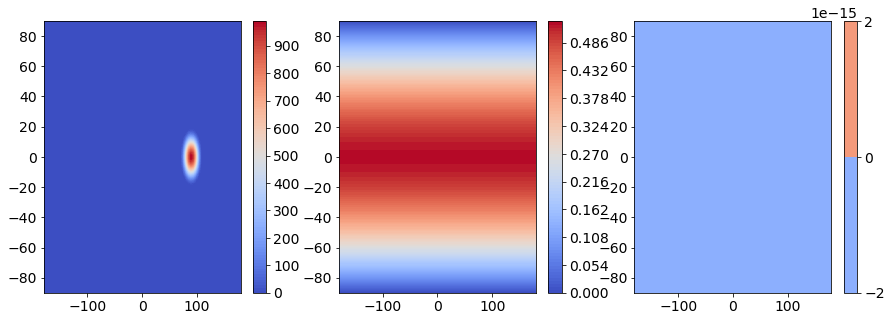

In [ ]:
# Plot initial solution
x = np.linspace(lmbdleft, lmbdright, 100)
y = np.linspace(thtlower, thtupper, 100)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, H*h0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()

plt.subplot(132)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, U*u0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()

plt.subplot(133)
plt.contourf(360/2/np.pi*X, 360/2/np.pi*Y, v0(X,Y), 100, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

### Subclassing layers

In [ ]:
class PeriodicSphere(tf.keras.layers.Layer):
  def __init__(self, name=None, **kwargs):
    super(PeriodicSphere, self).__init__(name=name)
    super(PeriodicSphere, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.concat((tf.cos(inputs[1])*tf.cos(inputs[0]),
               tf.cos(inputs[1])*tf.sin(inputs[0]),
               tf.sin(inputs[1])), axis=1)

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [ ]:
class AdaptiveActivation(tf.keras.layers.Layer):

  def __init__(self, name=None, **kwargs):
    super(AdaptiveActivation, self).__init__(name=name)
    init = tf.keras.initializers.ones()

    self.a = tf.Variable(initial_value=init(shape=(1,)), dtype=tf.float64, trainable=True)
    super(AdaptiveActivation, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.math.tanh(self.a*inputs)  

### Define the network

In [ ]:
def build_model(t0, tfinal, n_units=20, n_layers=4, summary=False):

  # Define the network
  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp1)

  inp2 = tf.keras.layers.Input(shape=(1,))
  inp3 = tf.keras.layers.Input(shape=(1,))
  b23 = PeriodicSphere()([inp2, inp3])

  b = tf.keras.layers.Concatenate()([b1, b23])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, 'tanh', kernel_initializer='glorot_normal')(b)
    # b = AdaptiveActivation()(b)
  out = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(b)

  model = tf.keras.models.Model([inp1, inp2, inp3], out)
  
  if summary:
    model.summary()

  return model

### Training routines

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, y_bdry, N_pde=50000, N_iv=10000):

  # Convert input to numpy array
  t_bdry, x_bdry, y_bdry = np.array(t_bdry), np.array(x_bdry), np.array(y_bdry)
  
  # Uniform random sampling on a sphere
  txy_min = np.array([t_bdry[0], x_bdry[0], 0])
  txy_max = np.array([t_bdry[1], x_bdry[1], 1])  
  pde_points = txy_min + (txy_max - txy_min)*lhs(3, N_pde)
  t_pde = pde_points[:, 0]
  x_pde = pde_points[:, 1]
  y_pde = np.arccos(1-2*pde_points[:, 2]) + y_bdry[0]
  
  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde, y_pde]).astype(np.float64)
  pdes = pdes[np.argsort(pdes[:,0])]  

  # Uniform random sampling on a sphere for initial values
  init_points = txy_min[1:] + (txy_max[1:] - txy_min[1:])*lhs(2, N_iv)
  x_init = init_points[:, 0]
  y_init = np.arccos(1-2*init_points[:, 1]) + y_bdry[0]
  t_init = t_bdry[0]+0*x_init

  # Stack all the ivp data together
  inits = np.column_stack([t_init, x_init, y_init]).astype(np.float64)

  return (pdes, inits)

In [ ]:
N_pde, N_iv = 100000, 10000
(pdes, inits) = defineCollocationPoints([t0, tfinal], [lmbdleft, lmbdright], [thtlower, thtupper], N_pde, N_iv)

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10,10))
# ax = Axes3D(fig)
# ax.scatter(pdes[:,0], pdes[:,1], pdes[:,2])
# ax.view_init(0, 90)
# plt.xlabel('t')
# plt.ylabel('x')
# plt.show()

In [ ]:
@tf.function
def train_network(pdes, inits, u0, v0, model):

    # PDE points and associated self-adaptation weights
    t_pde, x_pde, y_pde = pdes[:,:1], pdes[:,1:2], pdes[:,2:3]

    # Initial value points and associated self-adaptation weights
    t_init, x_init, y_init = inits[:,:1], inits[:,1:2], inits[:,2:3]
    h_init = inits[:,3:4]

  # Outer gradient for tuning network parameters
    with tf.GradientTape(persistent=True) as tape:

      # Inner gradient for derivatives of u wrt x and t
      with tf.GradientTape() as tape2:
        tape2.watch(t_pde), tape2.watch(x_pde), tape2.watch(y_pde)
        h = model([t_pde, x_pde, y_pde], training=True)  
      [dhdt, dhdx, dhdy] = tape2.gradient(h, [t_pde, x_pde, y_pde])

      # Solve the linear advection equation
      eqn = dhdt + u0(x_pde,y_pde)/tf.cos(y_pde)*dhdx + v0(x_pde,y_pde)*dhdy

      # Define the PDE loss  
      PDEloss = tf.reduce_mean(tf.square(eqn))

      # Define the IVP loss
      h_init_pred = model([t_init, x_init, y_init], training=True)
      ICloss = tf.reduce_mean(tf.square(h_init-h_init_pred))

    # Compute loss weighting
    gradPDE = tape.gradient(PDEloss, model.trainable_variables)
    gradIVP = tape.gradient(ICloss, model.trainable_variables)
    gradPDE_f = tf.concat([tf.reshape(p, [-1]) for p in gradPDE], axis=0)
    gradIVP_f = tf.concat([tf.reshape(p, [-1]) for p in gradIVP], axis=0)

    # Project conflicting gradients
    if tf.reduce_sum(tf.multiply(gradIVP_f, gradPDE_f)) < 0:
      if tf.random.uniform([1]) < 0.5:
        proj = tf.reduce_sum(tf.multiply(gradPDE_f, gradIVP_f))/tf.reduce_sum(tf.square(gradIVP_f))
        gradPDE = [gPDE - proj*gIVP for gPDE, gIVP in zip(gradPDE, gradIVP)]
      else:
        proj = tf.reduce_sum(tf.multiply(gradPDE_f, gradIVP_f))/tf.reduce_sum(tf.square(gradPDE_f))
        gradIVP = [gIVP - proj*gPDE for gPDE, gIVP in zip(gradPDE, gradIVP)]

    # Compute the gradient of the global loss wrt the model parameters
    grads = [gPDE+gIVP for gPDE, gIVP in zip(gradPDE, gradIVP)]

    return PDEloss, ICloss, grads

In [ ]:
def PINNtrain(pde_points, inits, u0, v0, epochs=10000):

  N_pde, N_iv = len(pde_points), len(inits)

  # Batch sizes
  bs_pdes, bs_inits = N_pde//10, N_iv//10

  # Boundaries for the models
  # model_boundaries = [0, 20000] + [20000+5000*i for i in range(1,(epochs-20000)//5000+1)]
  model_boundaries = [0,4500,9000,13500,epochs]
  # model_boundaries = [0,9000,13500,18000,epochs]  

  # model_boundaries = [0,1000,2000,3000,4000,5000,6000]
  lr_model = [1e-3 for i in range(100)]
  print(model_boundaries)
  print(len(model_boundaries)-1)

  nr_boundaries = len(model_boundaries)-1
  k = 0

  # initial value points
  t_init, x_init, y_init = inits[:,0], inits[:,1], inits[:,2]

  epoch_loss = np.zeros(epochs)
  nr_batches = 0

  # Main training loop
  for i in range(epochs):

    # Train a new model
    if np.mod(i, model_boundaries[k]) == 0:
      k +=1

      # Generate the tf.Dataset for the initial data
      if k==1: # Use the actual initial conditions
        h_init = h0(x_init, y_init)
      else: # Use the previous model
        t_init = (k-1)*tfinal/nr_boundaries + 0*t_init
        h_init = model([np.expand_dims(t_init, axis=1), 
                     np.expand_dims(x_init, axis=1), 
                     np.expand_dims(y_init, axis=1)])[:,0]  

        # Save the previous model
        fname = "model" + str(k-1) + ".h5"
        model.save(fname)

      inits = np.column_stack([t_init, x_init, y_init, h_init])

      ds_init = tf.data.Dataset.from_tensor_slices(inits)
      ds_init = ds_init.cache().shuffle(N_iv).batch(bs_inits)
  
      # Generate the tf.Dataset for the collocation points
      N_ds = k*N_pde//nr_boundaries
      N_ds_ = (k-1)*N_pde//nr_boundaries
      pts = pde_points[N_ds_:N_ds]
      t_min, t_max = pts[:,0].min(), pts[:,0].max()

      ds_pde = tf.data.Dataset.from_tensor_slices(pde_points[N_ds_:N_ds])
      ds_pde = ds_pde.cache().shuffle(N_ds-N_ds_).batch(bs_pdes)
      ds = tf.data.Dataset.zip((ds_pde, ds_init))
      ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

      # Generate a new model
      opt = tf.keras.optimizers.Adam(lr_model[k-1])
      model = build_model(t_min, t_max) 

      # Copy over weights from old model
      if k>1:
        print("Copy over weights from previous model...")
        fname = "model" + str(k-1) + ".h5"
        model_ = tf.keras.models.load_model(fname, custom_objects={'Normalize': Normalize, 
                                                                   'PeriodicSphere': PeriodicSphere,
                                                                   'AdaptiveActivation': AdaptiveActivation})
        model.set_weights(model_.get_weights())

      print("\nTraining model no. {} for initial time {: 4.2f}, running over interval [{: 4.2f},{: 4.2f}] with lr={}.\n".format(k, t_init[0], t_min, t_max, lr_model[k-1]))

    # Training for that epoch
    for (pdes, inits) in ds:

      # Train the network
      PDEloss, ICloss, grads = train_network(pdes, inits, u0, v0, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += PDEloss + ICloss
      nr_batches += 1

    # Get total epoch loss
    epoch_loss[i] /= nr_batches
    nr_batches = 0

    if (np.mod(i, 100)==0):
      print("PDE loss, IV loss in {}th epoch: {: 6.4f}, {: 6.4f}.".format(i, PDEloss, ICloss))

  # Add the last model
  fname = "model" + str(k) + ".h5"
  model.save(fname)

  return epoch_loss, k

### Train the network

In [ ]:
epochs=18000
loss, nr_models = PINNtrain(pdes, inits, u0, v0, epochs)

[0, 4500, 9000, 13500, 18000]
4

Training model no. 1 for initial time  0.00, running over interval [ 0.00, 3.00] with lr=0.001.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in remainder


PDE loss, IV loss in 0th epoch:  0.0197,  0.0678.
PDE loss, IV loss in 100th epoch:  0.0001,  0.0041.
PDE loss, IV loss in 200th epoch:  0.0001,  0.0036.
PDE loss, IV loss in 300th epoch:  0.0001,  0.0055.
PDE loss, IV loss in 400th epoch:  0.0001,  0.0037.
PDE loss, IV loss in 500th epoch:  0.0001,  0.0023.
PDE loss, IV loss in 600th epoch:  0.0001,  0.0023.
PDE loss, IV loss in 700th epoch:  0.0001,  0.0038.
PDE loss, IV loss in 800th epoch:  0.0001,  0.0025.
PDE loss, IV loss in 900th epoch:  0.0001,  0.0043.
PDE loss, IV loss in 1000th epoch:  0.0001,  0.0033.
PDE loss, IV loss in 1100th epoch:  0.0002,  0.0019.
PDE loss, IV loss in 1200th epoch:  0.0003,  0.0015.
PDE loss, IV loss in 1300th epoch:  0.0003,  0.0008.
PDE loss, IV loss in 1400th epoch:  0.0003,  0.0006.
PDE loss, IV loss in 1500th epoch:  0.0002,  0.0003.
PDE loss, IV loss in 1600th epoch:  0.0002,  0.0002.
PDE loss, IV loss in 1700th epoch:  0.0002,  0.0002.
PDE loss, IV loss in 1800th epoch:  0.0001,  0.0001.
PDE l

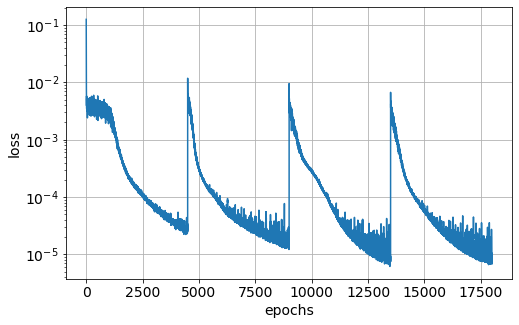

In [ ]:
plt.figure(figsize=(8,5))
plt.subplot(111)
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
# plt.axis([-100,epochs, loss.min(), loss.max()])
plt.savefig('loss.png')


In [ ]:
# Composite prediction function
def predict(nr_models,t,x,y):
  
  total_steps = len(t)
  steps_per_model = total_steps//nr_models
  h = np.zeros((total_steps, 1))
  
  for i in range(nr_models):
    curr_model = "model" + str(i+1) + '.h5'
    model = tf.keras.models.load_model(curr_model, custom_objects={'Normalize': Normalize, 
                                                                   'PeriodicSphere': PeriodicSphere,
                                                                   'AdaptiveActivation': AdaptiveActivation})
    
    tt = tf.Variable(t[i*steps_per_model:(i+1)*steps_per_model,])
    xx = tf.Variable(x[i*steps_per_model:(i+1)*steps_per_model,])
    yy = tf.Variable(y[i*steps_per_model:(i+1)*steps_per_model,])

    hh = model([tt,xx,yy])
    h[i*steps_per_model:(i+1)*steps_per_model,:] = hh
    
  return h

### Visualize results

In [ ]:
# Grid where to evaluate the model
l, m, n = days+1, 150, 75
t = np.linspace(t0, tfinal, l)
x = np.linspace(lmbdleft, lmbdright, m)
y = np.linspace(thtlower, thtupper, n)
T_p, X_p, Y_p  = np.meshgrid(t,x,y, indexing='ij')

dt = t[1]-t[0]

tt = np.expand_dims(T_p.flatten(), axis=1)
xx = np.expand_dims(X_p.flatten(), axis=1)
yy = np.expand_dims(Y_p.flatten(), axis=1)

h = predict(nr_models,tt,xx,yy)
h = np.reshape(h, (l, m, n))

In [ ]:
# filenames = []
# for i in range(l):
#   plt.figure(figsize=(10,5))
#   plt.subplot(121)
#   plt.contourf(X[i,], Y[i,], h[i,], np.linspace(-0.1,h00,100), cmap=plt.cm.coolwarm)
#   plt.clim(0,h00)
#   plt.title('Neural network solution')
#   plt.xlabel('lambda')
#   plt.ylabel('theta')
#   plt.colorbar()

#   plt.subplot(122)
#   plt.contourf(X[i,], Y[i,], h[i,]-h0(X[i,]-u0(X[i,],Y[i,])*T[i,]/np.cos(Y[i,]), Y[i,]-v0(X[i,],Y[i,])*T[i,]), 100, cmap=plt.cm.coolwarm)
#   plt.xlabel('lambda')
#   plt.ylabel('theta')
#   plt.title("Difference NN solution and true solution")
#   plt.colorbar()

#   filename = f'{i}.png'
#   filenames.append(filename)
#   plt.savefig(filename)
#   plt.close()

# with imageio.get_writer('mygif.gif', mode='I') as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# for filename in set(filenames):
#   os.remove(filename)

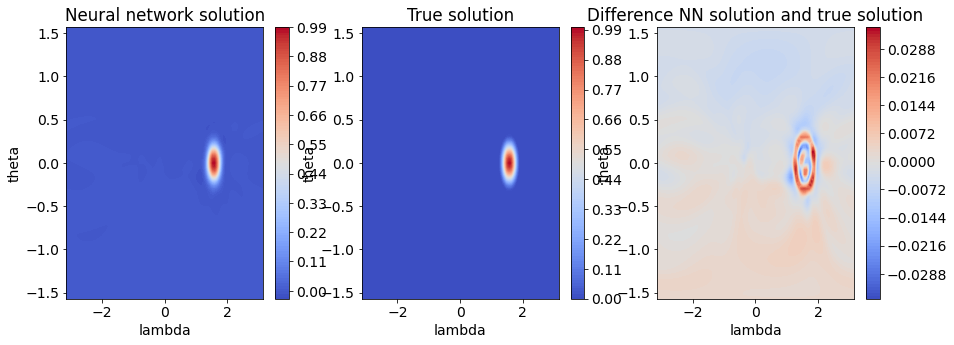

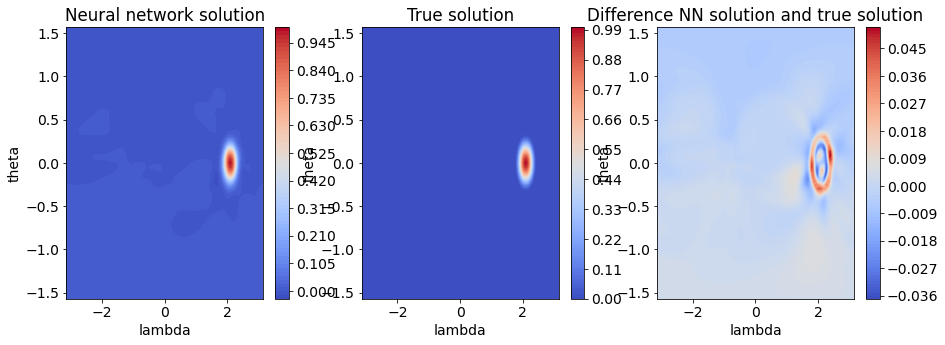

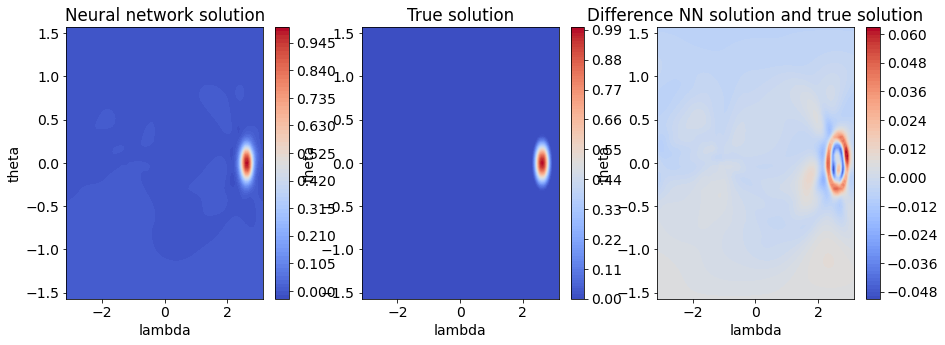

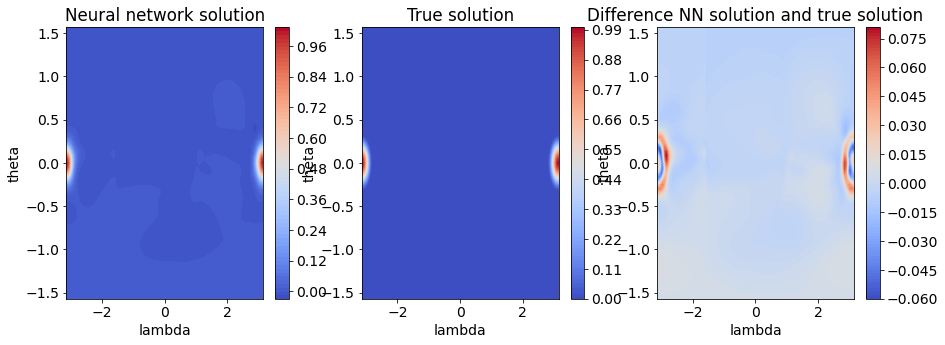

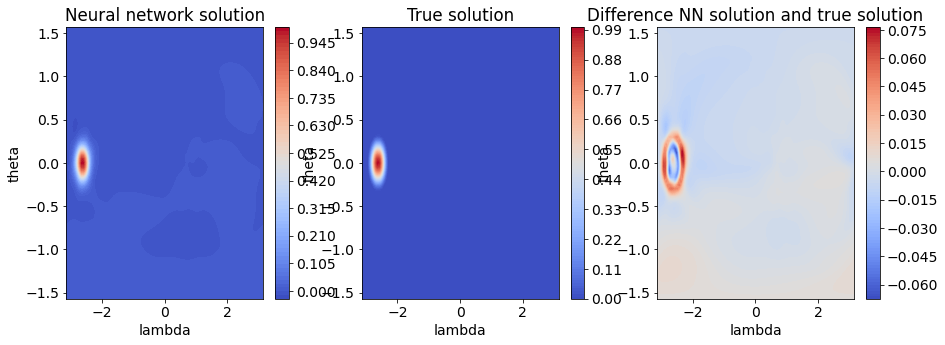

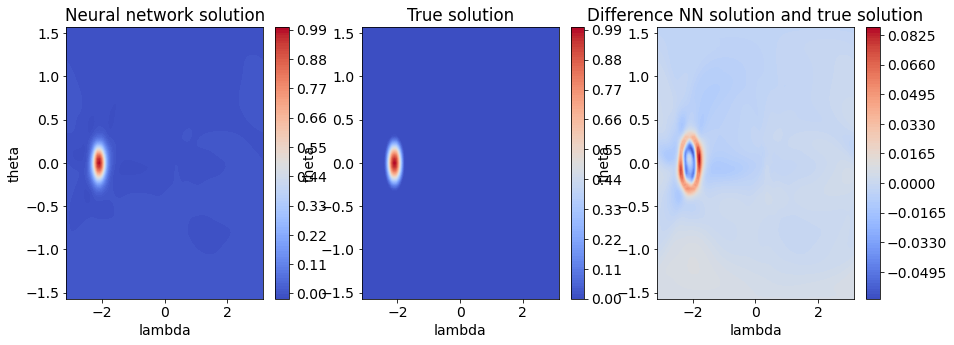

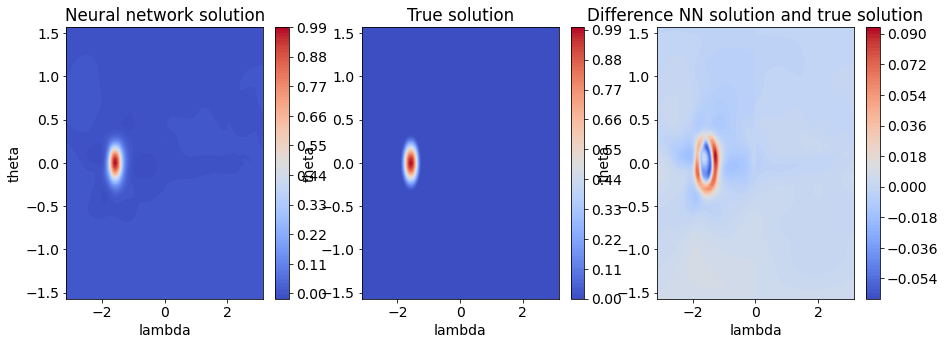

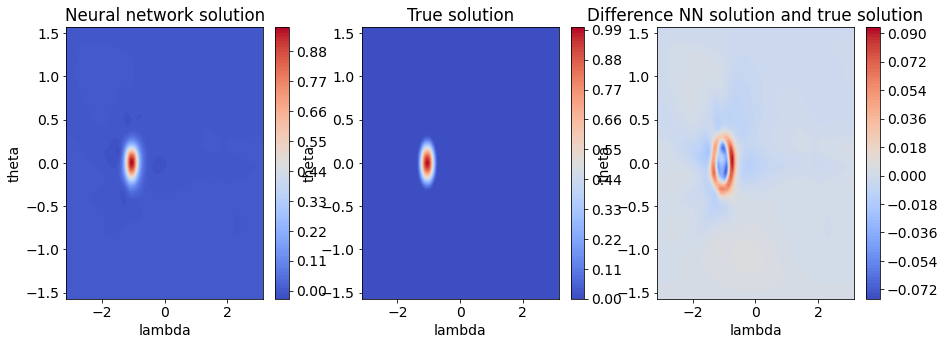

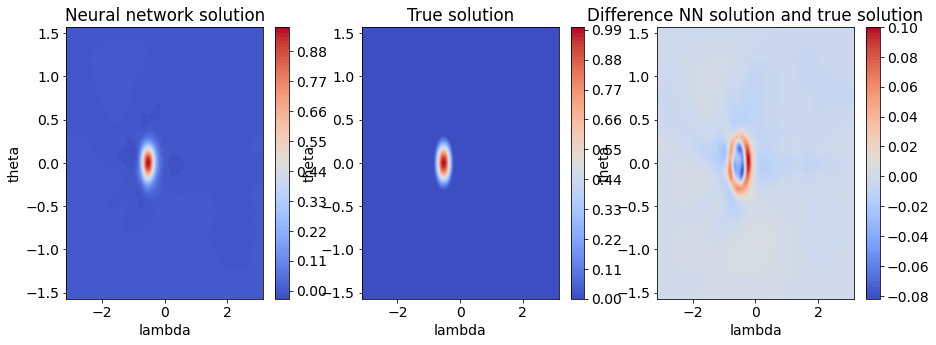

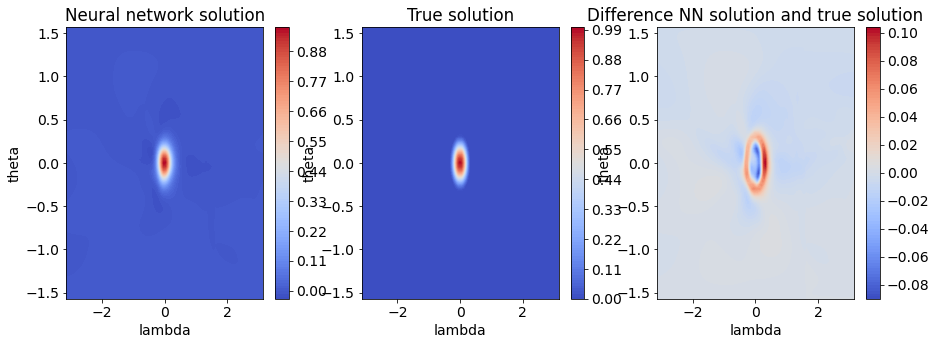

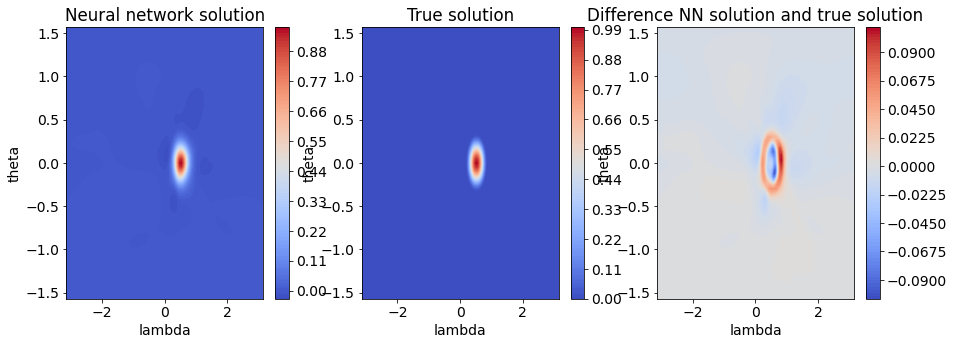

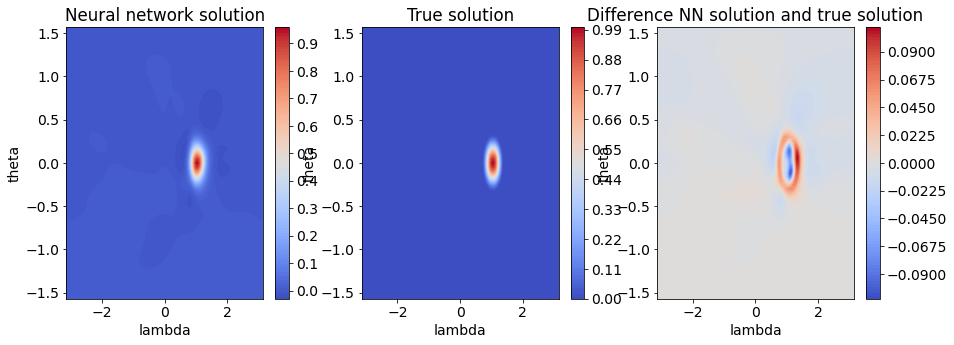

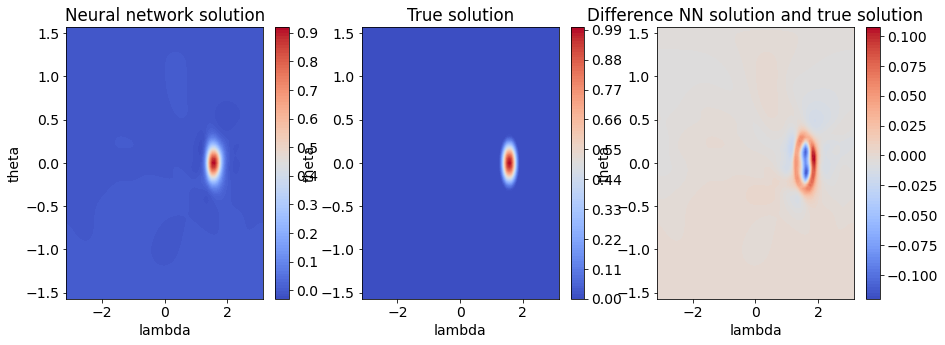

In [ ]:
for i in range(0,l):
  plt.figure(figsize=(15,5))
  plt.subplot(131)
  plt.contourf(X_p[i,], Y_p[i,], h[i,], 100, cmap=plt.cm.coolwarm)
  plt.title('Neural network solution')
  plt.xlabel('lambda')
  plt.ylabel('theta')
  plt.colorbar()

  plt.subplot(132)
  h_true = h0(X_p[i,]-u0(X_p[i,],Y_p[i,])*T_p[i,]/np.cos(Y_p[i,]), Y_p[i,]-v0(X_p[i,],Y_p[i,])*T_p[i,])
  plt.contourf(X_p[i,], Y_p[i,], h_true, 100, cmap=plt.cm.coolwarm)
  plt.title('True solution')
  plt.xlabel('lambda')
  plt.ylabel('theta')
  plt.colorbar()

  plt.subplot(133)
  plt.contourf(X_p[i,], Y_p[i,], h[i,]-h_true, 100, cmap=plt.cm.coolwarm)
  plt.xlabel('lambda')
  plt.ylabel('theta')
  plt.title("Difference NN solution and true solution")
  plt.colorbar()
  plt.show()

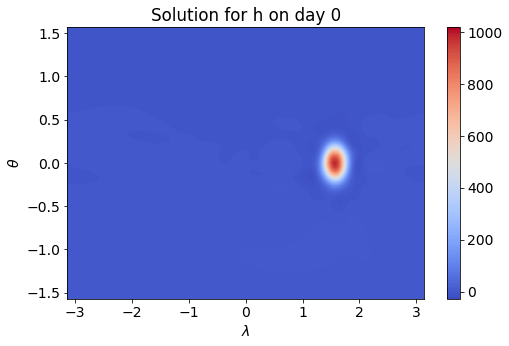

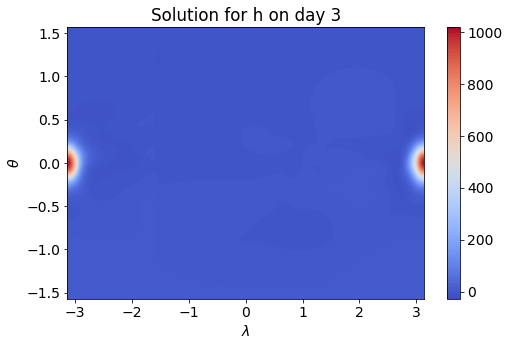

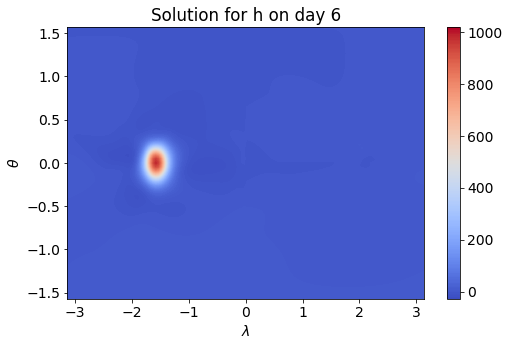

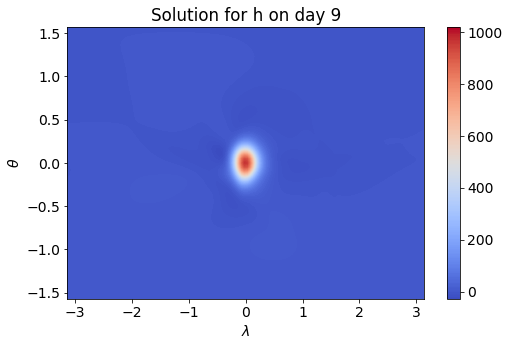

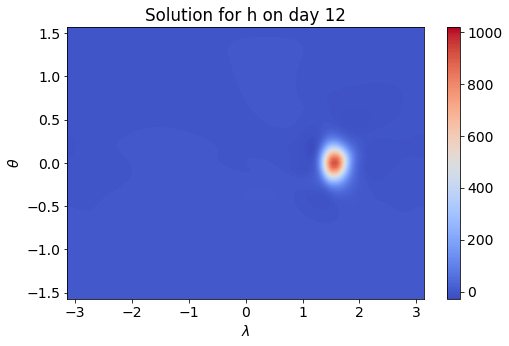

In [ ]:
# Grid where to evaluate the model
l, m, n = days+1, 150, 75
t = np.linspace(t0, tfinal, l)
x = np.linspace(lmbdleft, lmbdright, m)
y = np.linspace(thtlower, thtupper, n)
T_p, X_p, Y_p  = np.meshgrid(t,x,y, indexing='ij')

dt = t[1]-t[0]

tt = np.expand_dims(T_p.flatten(), axis=1)
xx = np.expand_dims(X_p.flatten(), axis=1)
yy = np.expand_dims(Y_p.flatten(), axis=1)

h = predict(nr_models,tt,xx,yy)
h = np.reshape(h, (l, m, n))

plot_steps = [0,1,2,3,4]
h00 = 1000

for i in plot_steps:
  plt.figure(figsize=(8,5))
  plt.subplot(111)
  plt.contourf(X_p[i,], Y_p[i,], h00*h[i*3,], np.linspace(-28,h00+20,200), cmap=plt.cm.coolwarm)
  plt.colorbar(ticks=[0+200*j for j in range(6)])
  plt.title('Solution for h on day {}'.format(i*3))
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')
  fname = 'Williamson_1_day_' + str(i*3) + '.png'
  # plt.savefig(fname)
  # files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

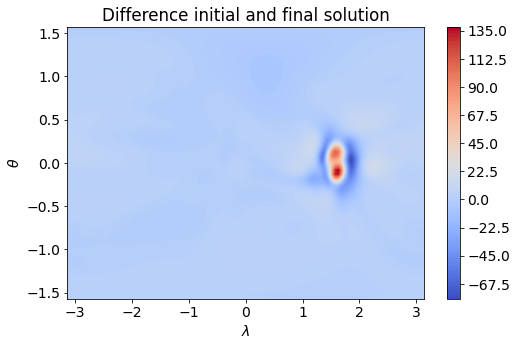

In [ ]:
  plt.figure(figsize=(8,5))
  plt.subplot(111)
  plt.contourf(X_p[0,], Y_p[0,], h00*(h[0,]-h[-1,]), 200, cmap=plt.cm.coolwarm)
  plt.colorbar()
  plt.title('Difference initial and final solution')
  plt.xlabel(r'$\lambda$')
  plt.ylabel(r'$\theta$')
  fname = 'Williamson_1_difference_initial_final.png'
  plt.savefig(fname)
  files.download(fname)